# Подготовка таблиц с данными

Задача этого ноутбука - очистка данных и составление таблиц для непосредственных расчетов. Речь о таблицах:
- заболевших (исходов)
- вакцинированных
- демографических групп населения Москвы
- серопревалентности по данным серомониторига из Dolzhikova et al., 2021


После очистки и агрегации получаются таблицы, которые записываются в соответствующие файлы csv. Дальнейшие расчеты эффективности проводятся затем на их основе. 

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
%matplotlib inline

## Ч.1 Готовая таблица заболевших (таблица исходов)


- df_raw - таблица в том виде, как предоставлена источником
- df_cases - то же, но без дублирующих суммирующих групп

In [2]:
df_raw = pd.read_excel('tables_in/source_tables.xlsx')

f1 = df_raw['vaccination_status']!='sum_data'
f2 = df_raw['outcome']!='sum_data'
f3 = df_raw['age_group']!='18+'

df_cases = df_raw[f1&f2&f3]

df_cases.head()

,table_id,month,age_group,vaccination_status,vaccine_type,outcome,cases,comment
1,table_1,june,18-50,V0,unknown,4-severe,974,непривитые
2,table_1,june,18-50,V1,unknown,4-severe,15,частично привитые
3,table_1,june,18-50,V2,unknown,4-severe,26,полностью привитые
5,table_1,june,18-50,V0,unknown,3-medium,10463,непривитые
6,table_1,june,18-50,V1,unknown,3-medium,227,частично привитые


- необходимо добавить данные о кейсах среди заболевших невакцинированных к table_2

In [3]:
f1= df_cases['table_id']=='table_1'
f2= df_cases['vaccination_status']=='V0'
f3= df_cases['outcome']=='4-severe'
df_cases[f1&f2&f3][['month', 'age_group', 'vaccination_status', 'outcome', 'cases', 'comment']]

,month,age_group,vaccination_status,outcome,cases,comment
1,june,18-50,V0,4-severe,974,непривитые
21,june,51-70,V0,4-severe,2429,непривитые
41,june,71-100,V0,4-severe,3153,непривитые
81,july,18-50,V0,4-severe,569,непривитые
101,july,51-70,V0,4-severe,1478,непривитые
121,july,71-100,V0,4-severe,2297,непривитые


In [4]:
df_cases.to_csv('tables_temp/df_cases.csv', index=False)

In [5]:
pd.read_csv('tables_temp/df_cases.csv')

,table_id,month,age_group,vaccination_status,vaccine_type,outcome,cases,comment
0,table_1,june,18-50,V0,unknown,4-severe,974,непривитые
1,table_1,june,18-50,V1,unknown,4-severe,15,частично привитые
2,table_1,june,18-50,V2,unknown,4-severe,26,полностью привитые
3,table_1,june,18-50,V0,unknown,3-medium,10463,непривитые
4,table_1,june,18-50,V1,unknown,3-medium,227,частично привитые
...,...,...,...,...,...,...,...,...
89,table_2,july,71-100,V0,kovivac,4-severe,2418,непривитые
90,table_3,june,18-50,V0,unknown,5-lethal,158,полностью привитые
91,table_3,june,18-50,V2,unknown,5-lethal,1,полностью привитые
92,table_3,june,51-100,V0,unknown,5-lethal,1700,полностью привитые


## Ч.2 Подготовка таблицы вакцинаций на основе выборки из реестра и официальных данных

### Задача
Задача: взять выборку из реестра вакцинаций и составить на ее основе таблицу вакцинаций.

### Начальная таблица

Исходный файл - temp.csv, содержит индивидуальные данные по сертификатам вакцинации без ФИО

`Номер;УНРЗ;Год рождения;Годен до;Вакцина;Серия`

### Конечная таблица вакцинаций

Таблица вакцинаций устроена следующим образом: 

- `date` - дата вакцинации, то есть дата второго укола, берется из "годен до" минус один год  
- `reg` - код региона, Москва это регион 77 - вот [Справочник](https://www.consultant.ru/document/cons_doc_LAW_108669/88a12659e7cc781c56303430d98ae6c8a683892a/)
- `vaccine_type` - наименование препарата
- `age_group` - возрастная группа
- `n_in_sample` - количество вакцинаций в собранном семпле
- `n` - абсолютное количество вакцинаций, реконструкция на основе официальных данных

### Очистка данных

При создании конечной таблицы:

- остаются только препараты с правильным наименованием - тем, что используется в подавляющем большинстве записей
- выбрасываются серии вакцинаций
- остаются только вакцинации по региону 77, Москве, т.к. дальнейший анализ учитывает только их
- агрегируются вакцинации по дням, возрастным группам и препаратам


In [6]:
df = pd.read_csv('tables_in/vaccinations_register_sample.csv',\
                 delimiter=';',\
                 dtype={'Вакцина':'category', 'Серия':'category'})

df['Годен до'] = pd.to_datetime(df['Годен до'], dayfirst=True)
df = df.set_index('Годен до', drop=True).sort_index()

- выкидываем вакцинные сертификаты со спорными названиями
- меняем полные названия вакцин на сокращенные

In [7]:
df['reg'] = [str(i)[:2] for i in df['УНРЗ']]

f1 = df['Вакцина']=='Гам-КОВИД-Вак Комбинированная векторная вакцина для профилактики коронавирусной инфекции, вызываемой вирусом SARS-CoV-2'
f2 = df['Вакцина']=='ЭпиВакКорона Вакцина на основе пептидных антигенов для профилактики COVID-19'
f3 = df['Вакцина']=='КовиВак (Вакцина коронавирусная инактивированная цельновирионная концентрированная очищенная)'
f4 = df['Вакцина']=='Спутник Лайт Векторная вакцина для профилактики коронавирусной инфекции, вызываемой вирусом SARS-CoV-2'

df['vaccine_type'] = None
df.loc[f1, 'vaccine_type']='sputnik'
df.loc[f2, 'vaccine_type']='epivac'
df.loc[f3, 'vaccine_type']='kovivac'
df.loc[f4, 'vaccine_type']='sputnik-l'

df2 = df[f1|f2|f3|f4]
df2 = df2[['Номер', 'reg',  'vaccine_type', 'Год рождения', 'Серия']]


Добавляем столбец возрастной группы. Нужны следующие группы возраста:

- 18-50
- 51-70
- 71-100

Также убираю те примерно 100 вакцинаций, которые приходятся на самое раннее время, до официального старта кампании

In [8]:
def get_age_category(birth_year):
    age = 2021-birth_year
    if  age<18:
        age_cat = '18-'
    elif 18<=age<=50:
        age_cat = '18-50'
    elif 50<age<=70:
        age_cat = '51-70'
    elif 70<age<=100:
        age_cat = '71-100'
    elif 100<age:
        age_cat = '100+'
    return age_cat        

df2['age_group'] = [get_age_category(i) for i in df2['Год рождения']]

df3 = df2[['Номер', 'reg', 'vaccine_type', 'age_group']]

df3 = df3['2021-12-05':]

- меняем даты Годен до на даты вакцинации (это второй укол)
- агрегируем по выданным номерам сертификатов
- сортируем

In [9]:
df4 =df3.shift(-365, 'D').reset_index()\
    .groupby(['Годен до', 'reg', 'vaccine_type', 'age_group'])\
    .count()\
    .reset_index()\
    .rename(columns={'Годен до':'date',\
                     'Номер':'n_in_sample'})\
    .sort_values(['date', 'reg', 'vaccine_type', 'age_group'])

 - Читаем таблицу общего числа вакцинированных из официальных данных

In [10]:
df_offvacdata = pd.read_excel('tables_in/source_tables.xlsx', sheet_name='vaccinations_official', header=1)
df_offvacdata['date'] = pd.to_datetime(df_offvacdata['date'], format='%Y-%m-%d')
df_offvacdata.set_index('date', drop=True, inplace=True)
df_offvacdata.sort_index(inplace=True)

df_offvacdata['v2'].dropna()

date
2021-03-26     800000.0
2021-04-15     820000.0
2021-05-18    1300000.0
2021-06-18    1500000.0
2021-06-26    1600000.0
2021-07-05    1800000.0
2021-07-07    1800000.0
2021-07-16    2000000.0
2021-07-20    2200000.0
2021-07-25    2694832.0
2021-08-01    3194373.0
2021-08-08    3556053.0
2021-08-11    3611289.0
2021-11-04    4410000.0
Name: v2, dtype: float64

Посмотрим на соотношение количества вакцинированных в выборке и официально объявленных, рассчитаем коэффициент, показывающий долю вакцинаций из выборки относительно всех официальных вакцинаций.

Во-первых, общее количество записей в выборке, которая заканчивается в август, составляет около процента от количества вакцинированных на 1 августа по официальным данным:

In [11]:
records_in_samle_Moscow = df[df['reg']=='77']['УНРЗ'].unique().shape[0]

off_data_Moscow = df_offvacdata.loc['2021-08-01', 'v2']

print(records_in_samle_Moscow,\
      off_data_Moscow, \
      records_in_samle_Moscow/off_data_Moscow,\
      off_data_Moscow/records_in_samle_Moscow )

30344 3194373.0 0.009499203756104876 105.27198128130767


### Подсчет суммарного числа вакцинированных по данным выборки

Теперь нужно подсчитать кумулятивное число привитых в выборке по дням. В выборке при этом есть значительное число пропущенных дней в самом начале. При подсчете кумулятивного числа привитых нужно либо:

- заполнять эти пропущенные значения нулями, `fillna(0)`
- заполнять эти пропущенные значеня предыдущими значениями, `ffill()`

Сначала кажется, что более правильный метод именно последний, так как со старта кампании вакцинации можно ожидать, что она продолжилась, а не начиналась, заканчивалась, и снова начиналась. Но для оценки общего кумулятивное числа вакцинированных нужен именно метод `fillna(0)`

In [12]:
df4.to_excel('temp1.xlsx')

In [13]:
df_Moscow = df4[df4['reg']=='77'].drop(columns='reg')
f1 = df_Moscow['vaccine_type']=='sputnik'
f2 = df_Moscow['vaccine_type']=='epivac'
df_Moscow = df_Moscow[f1|f2]
df_Moscow = pd.pivot_table(df_Moscow,\
                    index='date',\
                    values='n_in_sample',\
                    columns=['vaccine_type', 'age_group'],\
                    aggfunc='sum')\
                .fillna(0)\
                .cumsum()\
                .astype('int') # агрегация pivot_table оставила float нужно вернуться к int
df_Moscow

vaccine_type epivac              sputnik             
age_group     18-50 51-70 71-100   18-50 51-70 71-100
date                                                 
2020-12-07        0     0      0       2     2      0
2020-12-09        0     0      0       3     2      0
2020-12-10        0     0      0       4     3      0
2020-12-15        0     0      0       4     4      0
2020-12-16        0     0      0       6     4      0
...             ...   ...    ...     ...   ...    ...
2021-07-29      771   365     41   17029  7753   1389
2021-07-30      772   367     41   17593  7911   1397
2021-07-31      773   367     41   17978  8019   1404
2021-08-01      774   367     41   18298  8097   1411
2021-08-02      778   367     41   18720  8190   1419

[231 rows x 6 columns]

Найдем долю, которую составляет размер выборки от официального числа вакцинаций. Для этого сравним все значения в выборке на те даты, когда публиковались официальные данные. 

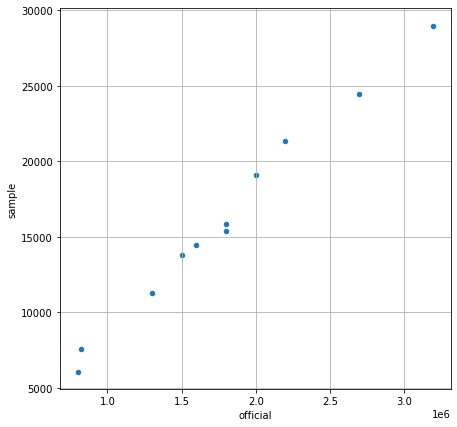

In [14]:
A = df_Moscow.sum(axis=1)
A.name = 'sample'
B = df_offvacdata['v2'].dropna()
B.name = 'official'

C = pd.merge(A,B,left_index=True, right_index=True)

C.plot.scatter('official', 'sample', figsize=(7,7), grid=True)

In [15]:
coefficient_sample_to_official = C.mean()['official']/C.mean()['sample']
coefficient_sample_to_official

110.56065093736328

Наконец, экспортируем две таблицы - с данными выборки и с данными, умноженными на коэффициент

In [16]:
df_Moscow.to_csv('tables_temp/vaccinations_Moscow_cumulative_sample.csv')

(df_Moscow*coefficient_sample_to_official)\
.astype('int')\
.to_csv('tables_temp/vaccinations_Moscow_cumulative_adjusted.csv')

In [17]:
pd.read_csv('tables_temp/vaccinations_Moscow_cumulative_adjusted.csv', header=[0,1], index_col=0).tail(3)

vaccine_type epivac                sputnik                
age_group     18-50  51-70 71-100    18-50   51-70  71-100
date                                                      
2021-07-31    85463  40575   4532  1987659  886585  155227
2021-08-01    85573  40575   4532  2023038  895209  156001
2021-08-02    86016  40575   4532  2069695  905491  156885

## Ч.3 Подготовка таблицы населения Москвы по возрастным группам


In [18]:
# Таблица распределения населения по возрастным группам

df_demographics = pd.read_excel('tables_in/rosstat_bulletin_2021.xlsx', \
                                sheet_name='2.1.18.', header=4, usecols=[0,1])\
                    .rename(columns={'Возраст (лет)':'age','Всё население':'population'})

df_demographics = df_demographics.set_index('age').filter(regex="^\d+$|80 и старше", axis=0)

def get_age_category(age_string):
    age = int(re.match('\d+', age_string)[0])
    if  age<18:
        age_cat = '18-'
    elif 18<=age<=50:
        age_cat = '18-50'
    elif 50<age<=70:
        age_cat = '51-70'
    elif 70<age<=100:
        age_cat = '71-100'
    elif 100<age:
        age_cat = '100+'
    return age_cat



df_demographics['age_group']=[get_age_category(i) for i in df_demographics.index]

df_demographics_temp = df_demographics.groupby('age_group').sum()['population']

# эта дополнительная категория понадобится дальше для анализа эффективности Спутника и Эпивака
df_demographics_temp['51-100'] = df_demographics_temp['51-70'] + df_demographics_temp['71-100']

df_demographics_temp.to_csv('tables_temp/demographics_Moscow_age_groups.csv')

In [19]:
pd.read_csv('tables_temp/demographics_Moscow_age_groups.csv')

,age_group,population
0,18-,2188233
1,18-50,5760116
2,51-70,3284276
3,71-100,1422425
4,51-100,4706701


## Ч.4 Подготовка таблицы серопревалентности по Москве на основе Dolzhikova et al., 2021


In [20]:
df_seroprevalence = pd.read_excel('tables_in/source_tables.xlsx',\
                                  sheet_name='seroprevalence',\
                                  skiprows=13,\
                                  index_col=0,\
                                  usecols=[0,1])
df_seroprevalence['month']='july'

In [21]:
df_seroprevalence.to_csv('tables_temp/df_seroprevalence.csv')